In [ ]:
!pip install pennylane
!pip install pennylane pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.3/913.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 9.7 MB/s eta 0:00:00


### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.templates import QFT
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml, load_digits
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from pennylane import numpy as pnp
from skimage.transform import resize
from keras.datasets import mnist

### Step 1:  Dataset Preparation

* Load MIST dataset - 0/1 pixel intensities
* Reduce image to 8x8
    * Resizing using skimage
    * Crop and pad (zero-padding)
* Normalize all images:
  8x8 image -> flatten -> vector of length 64 -> normalize
* Train/Test split

In [ ]:
# loading mnist from openML
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist['data'].astype(np.uint8) # better to convert for binerization
y = mnist['target'].astype(np.uint8)
y = y.to_numpy()

Here, I've been experimenting with different classes, and I stopped on 4 vs 9, cause they have more subtle difference in pixels, they are similar looking.

In [ ]:
# focus on binary classification
mask = (y == 4) | (y == 9)
X, y = X[mask], y[mask]
X.shape

(13782, 784)

In [ ]:
n_samples = 1000 # restricting to 6000 samples for now

X = X.values if hasattr(X, "values") else X # safer conversion
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

X = X[:n_samples]
y = y[:n_samples]

Binarising (makes amplitude preparation stable and simplifies qjpeg vectorization)

In [ ]:
X_bin = (X > 127).astype(np.uint8)
X_bin = np.array(X_bin)
X_bin.shape

(1000, 784)

Reducing images to 8x8 + flattening to (, 64)

In [ ]:
# convert each 28x28 binarised image to 8x8, then flatten to length 64
def to_8x8_vector(img_row):
    img_2d = np.array(img_row).reshape(28, 28).astype(float)        # reshape flat 784 -> 28x28
    img_8x8 = resize(
        img_2d,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True,
        order=1 # controlling interpolation
    )
    return img_8x8.flatten()   # should be shape (64,)

# apply to all images
X_8x8 = np.array([to_8x8_vector(x) for x in X_bin], dtype=float)
X_8x8.shape

(1000, 64)

L2-normalization of the vectors:

In [ ]:
def safe_l2_normalize_rows(X):
    X = X.astype(float)
    Xn = np.zeros_like(X, dtype=float)

    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    Xn = X / norms
    return Xn

X_8x8_norm = safe_l2_normalize_rows(X_8x8)
print("Any NaNs?", np.isnan(X_8x8_norm).any())
print("Norm check:", np.min(np.linalg.norm(X_8x8_norm, axis=1)), np.max(np.linalg.norm(X_8x8_norm, axis=1)))

Any NaNs? False
Norm check: 0.9999999999999998 1.0000000000000002


In [ ]:
X_8x8_norm.shape

(1000, 64)

I'm gonna do the splitting here, and carry both representations consistently

In [ ]:
idx = np.arange(n_samples)

idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y
)

# QEK inputs (8x8 -> 64 -> normed)
X_train_qek = X_8x8_norm[idx_train]
X_test_qek  = X_8x8_norm[idx_test]

# QJPEG inputs (28x28 binary images)
X_train_img = X_bin[idx_train]
X_test_img  = X_bin[idx_test]

print("QEK train/test:", X_train_qek.shape, X_test_qek.shape)
print("IMG train/test:", X_train_img.shape, X_test_img.shape)
print("Labels train/test:", y_train.shape, y_test.shape)

QEK train/test: (800, 64) (200, 64)
IMG train/test: (800, 784) (200, 784)
Labels train/test: (800,) (200,)


Data preparation is done.

### Step 2: Quantum Embedding & Kernel Training

In [ ]:
n_qubits = 6
wires = list(range(n_qubits))

dev = qml.device("lightning.qubit", wires=wires, shots=None)

Defining QEK circuit

In [ ]:
def qek_circuit(x, theta):
    """
    Quantum Embedding Kernel circuit U(x; theta)
    """
    layers = theta.shape[0]

    # Encode classical data
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True)

    # parameterized layers with entanglement
    for l in range(layers):
        for i in range(n_qubits):
            # RX, RY, RZ rotations per qubit
            qml.RX(theta[l, i, 0], wires=i)
            qml.RY(theta[l, i, 1], wires=i)
            qml.RZ(theta[l, i, 2], wires=i)

        # entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
        # wrap-around entanglement
        qml.CNOT(wires=[n_qubits-1, 0])

    return qml.state()  # return full quantum state for kernel computation

# Wrap as QNode
qnode = qml.QNode(qek_circuit, dev)

Now we should generate quantum states - we embed training data only here.

In [ ]:
layers = 2
# trainable parameters theta initialised here
theta = np.random.uniform(0, 2*np.pi, size=(layers, n_qubits, 3))

# generating quantum states for all images
states_train = np.array([qnode(x, theta) for x in X_train_qek])
states_train.shape

(800, 64)

`states_train` is the quantum feature map. Now we compute kernel matrix

In [ ]:
def compute_kernel_matrix(states):
    num_train = states.shape[0]
    K_train = np.zeros((num_train, num_train))
    for i in range(num_train):
        # improving the computation time by using symmetry here
        for j in range(i, num_train):
            val = np.abs(np.vdot(states[i], states[j]))**2
            K_train[i,j] = val
            K_train[j,i] = val
    return K_train

# Regularize tiny/zero entries
epsilon = 1e-6
K_train = compute_kernel_matrix(states_train)
K_train_norm = K_train / K_train.max()

# sanity check
print("Kernel matrix:")
print(K_train)
print("Diagonal:", np.mean(np.diag(K_train))) # must be around 1
print("Min:", K_train.min(), "Max:", K_train.max())

Kernel matrix:
[[1.         0.22586245 0.48988675 ... 0.13807056 0.24161545 0.64451677]
 [0.22586245 1.         0.18462423 ... 0.0683426  0.09411393 0.39335489]
 [0.48988675 0.18462423 1.         ... 0.36099955 0.30179212 0.6230832 ]
 ...
 [0.13807056 0.0683426  0.36099955 ... 1.         0.23464564 0.23514403]
 [0.24161545 0.09411393 0.30179212 ... 0.23464564 1.         0.1619017 ]
 [0.64451677 0.39335489 0.6230832  ... 0.23514403 0.1619017  1.        ]]
Diagonal: 0.9999999999999987
Min: 4.81482486096809e-35 Max: 1.0


In [ ]:
svc = SVC(kernel='precomputed', C=1.0)
svc.fit(K_train_norm, y_train)

SVC(kernel='precomputed')

In [ ]:
print("Support vectors per class:", svc.n_support_)
print("Total support vectors:", svc.support_.shape)

Support vectors per class: [169 161]
Total support vectors: (330,)


In [ ]:
layers_list = [2, 4, 6, 8, 10, 12]
max_layers = max(layers_list)
theta_base = np.random.uniform(0, 2*np.pi, size=(max_layers, n_qubits, 3))


Layers 2: accuracy = 0.8600


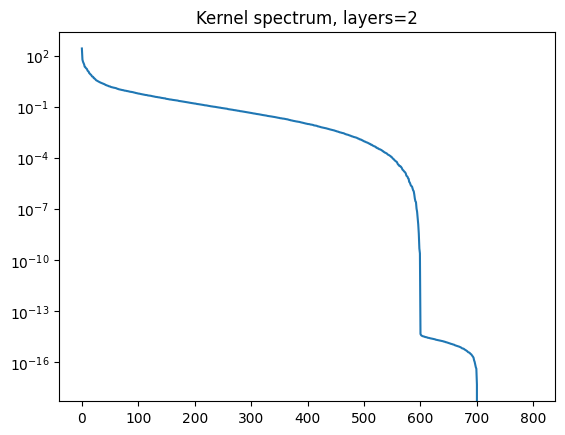

Layers 4: accuracy = 0.8600


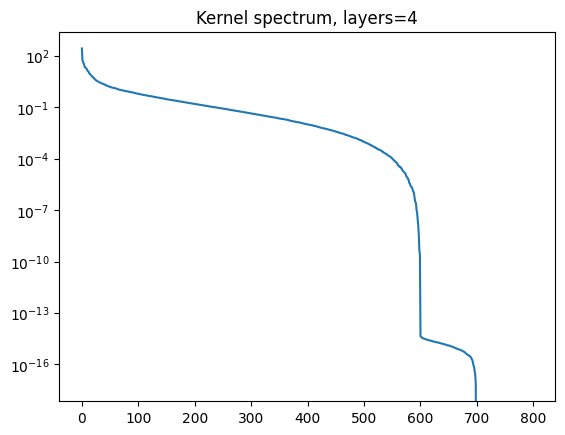

Layers 6: accuracy = 0.8600


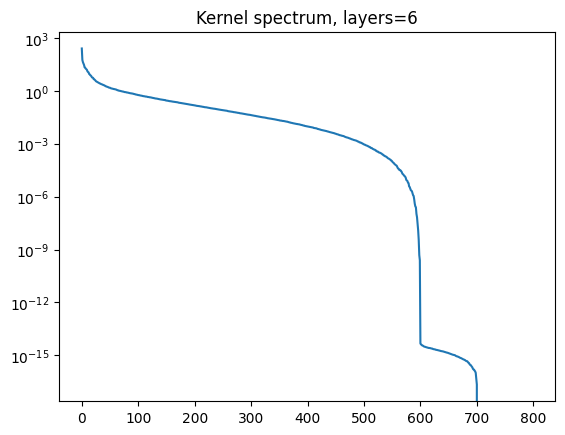

Layers 8: accuracy = 0.8600


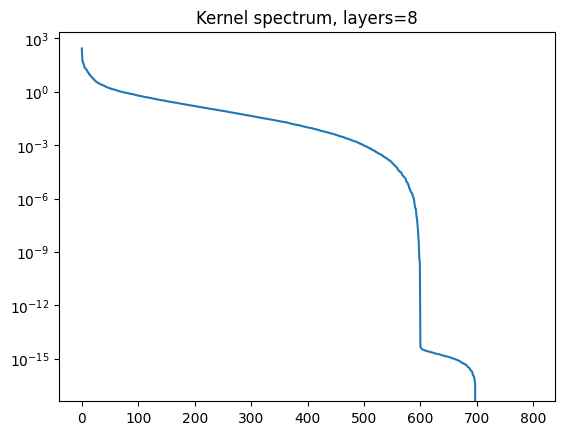

Layers 10: accuracy = 0.8600


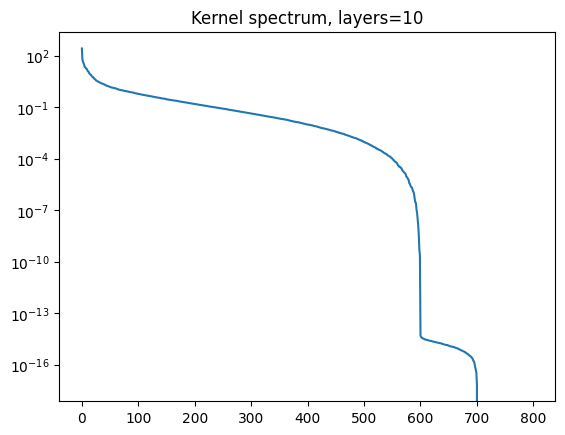

Layers 12: accuracy = 0.8600


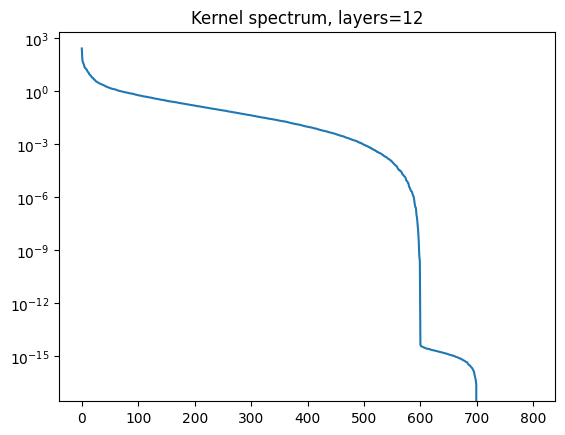

In [ ]:
def test_layers(X_train, X_test, y_train, y_test, layers_list):
    results = {}
    for layers in layers_list:
        theta = theta_base[:layers]   # PREFIX, not new random circuit

        states_train = np.array([qnode(x, theta) for x in X_train])
        states_test = np.array([qnode(x, theta) for x in X_test])

        K_train = compute_kernel_matrix(states_train)
        K_test = np.array([
            [np.abs(np.vdot(tr, ts))**2 for tr in states_train]
            for ts in states_test
        ])

        svc = SVC(kernel='precomputed', C=1.0)
        svc.fit(K_train, y_train)

        y_pred = svc.predict(K_test)
        acc = accuracy_score(y_test, y_pred)
        results[layers] = acc
        print(f"Layers {layers}: accuracy = {acc:.4f}")

        eigs = np.linalg.eigvalsh(K_train)
        plt.semilogy(eigs[::-1])
        plt.title(f"Kernel spectrum, layers={layers}")
        plt.show()

    return results

layer_results = test_layers(X_train_qek, X_test_qek, y_train, y_test, [2,4,6,8,10,12])

deeper layers -> slower eigenvalue decay

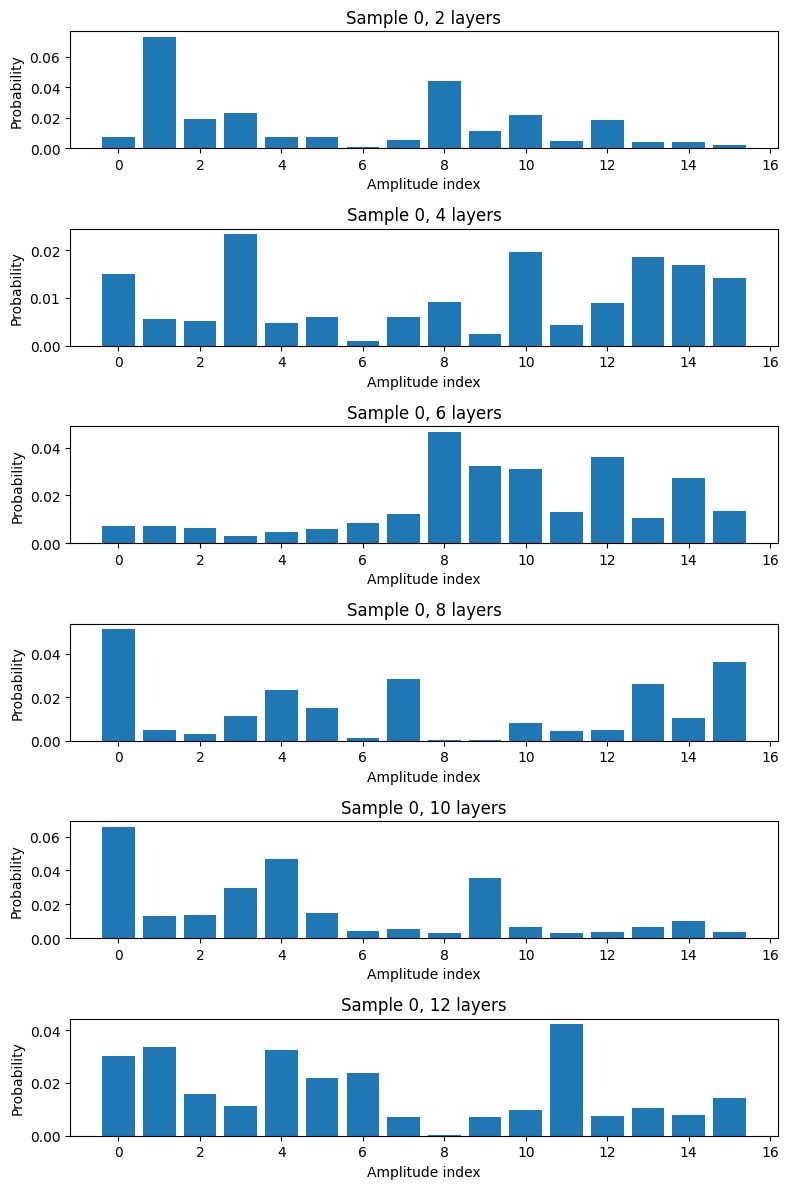

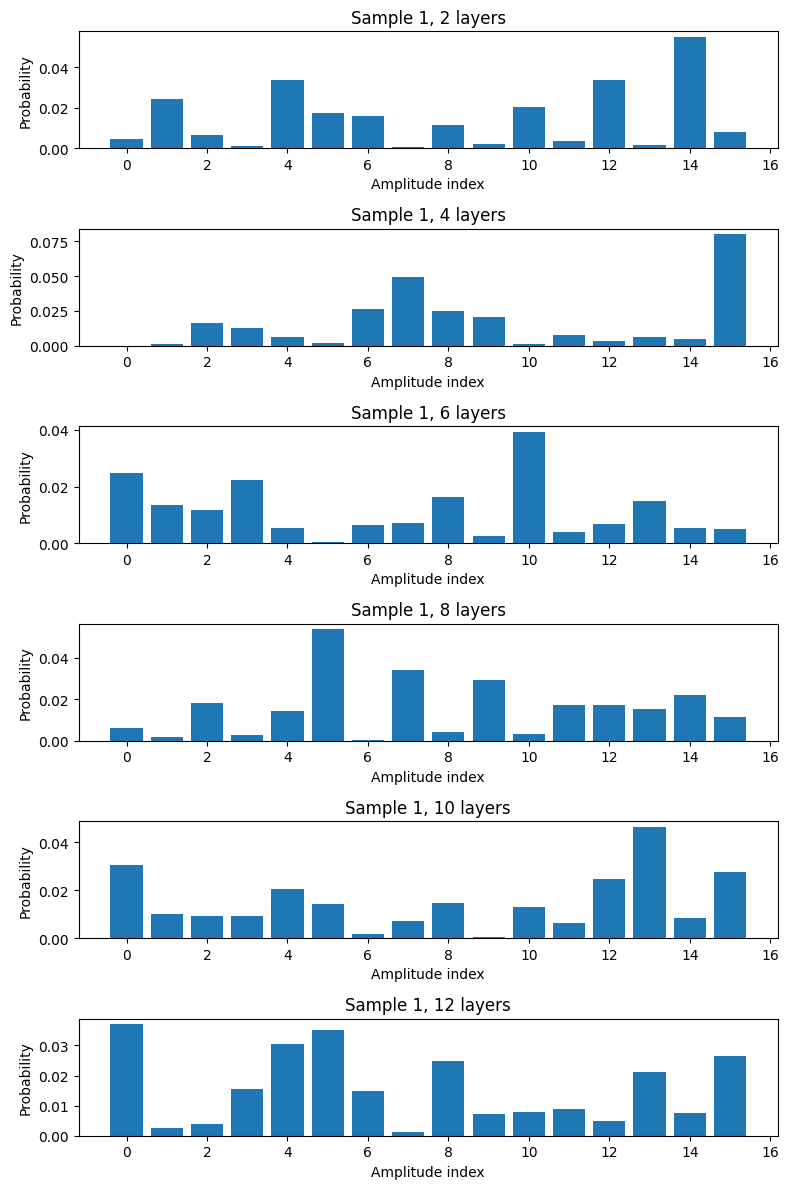

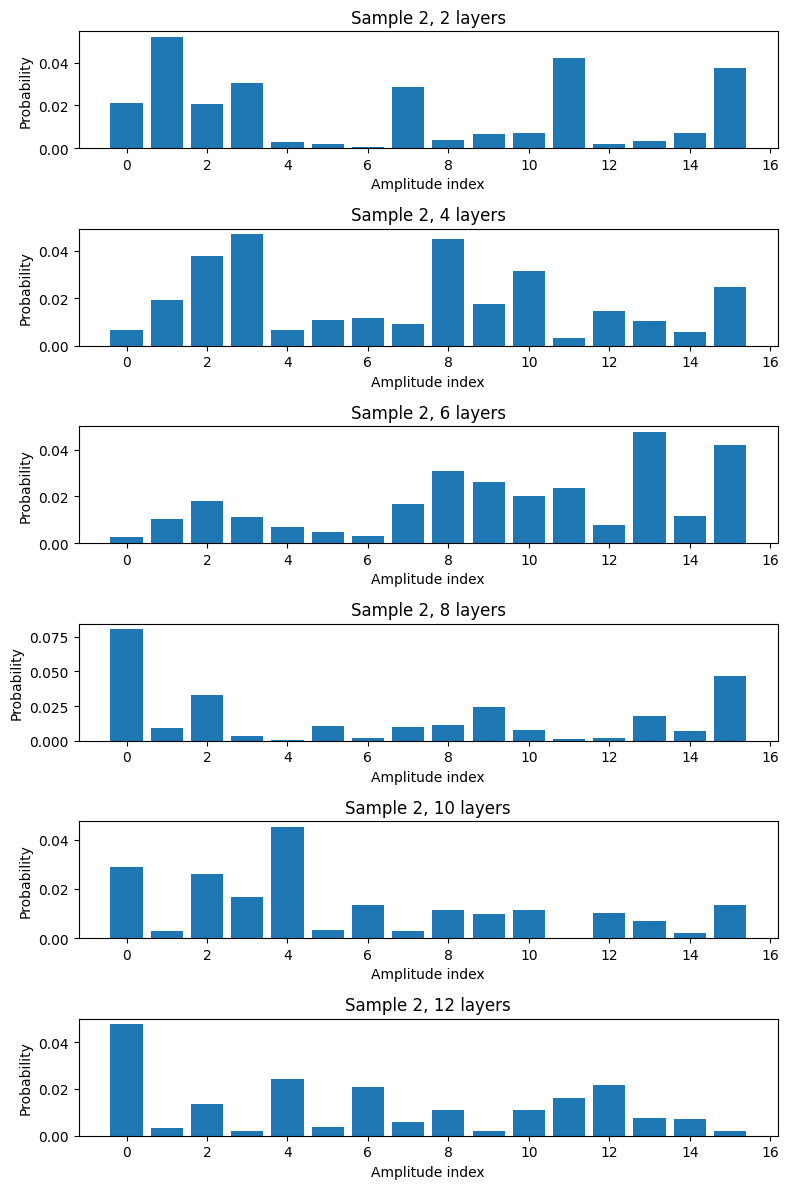

In [ ]:
# sanity check - how probabilities spread across basis states
# Pick a few sample images
sample_idx = [0, 1, 2]
layers_list = [2, 4, 6, 8, 10, 12]

for idx in sample_idx:
    fig, axes = plt.subplots(len(layers_list), 1, figsize=(8, 2*len(layers_list)))
    img_vec = X_train_qek[idx]

    for i, layers in enumerate(layers_list):
        # Generate theta for the current number of layers
        theta = theta_base[:layers]
        # Compute state
        state = qnode(img_vec, theta)

        # Plot first few amplitudes (e.g., first 16)
        axes[i].bar(range(16), np.abs(state[:16])**2)
        axes[i].set_title(f"Sample {idx}, {layers} layers")
        axes[i].set_ylabel("Probability")
        axes[i].set_xlabel("Amplitude index")

    plt.tight_layout()
    plt.show()

-> Hyperparameter grid search

In [ ]:
from itertools import product
from sklearn.metrics import accuracy_score

# Grid of hyperparameters
layers_list = [2, 4, 6, 8, 10, 12]     # number of circuit layers
C_list      = [0.01, 0.1, 1.0] # SVM regularization

max_layers = max(layers_list)
theta_base = np.random.uniform(0, 2*np.pi, size=(max_layers, n_qubits, 3))

def grid_search_qek_svm(X_train, X_test, y_train, y_test, layers_list, C_list):
    results = []

    for layers, C in product(layers_list, C_list):
        # Slice theta for current number of layers
        theta = theta_base[:layers]

        # Generate quantum states
        states_train = np.array([qnode(x, theta) for x in X_train])
        states_test  = np.array([qnode(x, theta) for x in X_test])

        # Compute kernels
        K_train = compute_kernel_matrix(states_train)
        K_train_norm = K_train / K_train.max()

        K_test = np.array([
            [np.abs(np.vdot(tr, ts))**2 for tr in states_train]
            for ts in states_test
        ]) / K_train.max()

        # Train SVM
        svc = SVC(kernel="precomputed", C=C)
        svc.fit(K_train_norm, y_train)

        # Predict and compute accuracy
        y_pred = svc.predict(K_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"Layers={layers}, C={C:.3f} --> Accuracy: {acc:.4f}")
        results.append((layers, C, acc))

    return results


In [ ]:
grid_results = grid_search_qek_svm(
    X_train_qek, X_test_qek, y_train, y_test, layers_list, C_list
)

import pandas as pd

df_results = pd.DataFrame(grid_results, columns=['Layers', 'C', 'Accuracy'])
print(df_results)

# Find best combination
best_row = df_results.loc[df_results['Accuracy'].idxmax()]
print("Best config:", best_row)

Layers=2, C=0.010 --> Accuracy: 0.5200
Layers=2, C=0.100 --> Accuracy: 0.8400
Layers=2, C=1.000 --> Accuracy: 0.8600
Layers=4, C=0.010 --> Accuracy: 0.5200
Layers=4, C=0.100 --> Accuracy: 0.8400
Layers=4, C=1.000 --> Accuracy: 0.8600
Layers=6, C=0.010 --> Accuracy: 0.5200
Layers=6, C=0.100 --> Accuracy: 0.8400
Layers=6, C=1.000 --> Accuracy: 0.8600
Layers=8, C=0.010 --> Accuracy: 0.5200
Layers=8, C=0.100 --> Accuracy: 0.8400
Layers=8, C=1.000 --> Accuracy: 0.8600
Layers=10, C=0.010 --> Accuracy: 0.5200
Layers=10, C=0.100 --> Accuracy: 0.8400
Layers=10, C=1.000 --> Accuracy: 0.8600
Layers=12, C=0.010 --> Accuracy: 0.5200
Layers=12, C=0.100 --> Accuracy: 0.8400
Layers=12, C=1.000 --> Accuracy: 0.8600
    Layers     C  Accuracy
0        2  0.01      0.52
1        2  0.10      0.84
2        2  1.00      0.86
3        4  0.01      0.52
4        4  0.10      0.84
5        4  1.00      0.86
6        6  0.01      0.52
7        6  0.10      0.84
8        6  1.00      0.86
9        8  0.01      

### Step 3: QJPEG Compression

In [ ]:
def vectorization(img, Cr, Cc, renorm=False):
    "Vectorize the image into amplitude-encoding patches suitable for quantum circuits"
    # splitting the original image (Mr, Mc) into S equal-size patches of shape (Cr, Cc)
    Mr, Mc = img.shape
    assert Mr % Cr == 0 and Mc % Cc == 0
    patches = (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2).reshape(-1, Cr, Cc))
    # 64 patches, (64, 64, 64) shape; S=64

    # vectorize each patch and collect all in a (N, Cr*Cc) array
    vect_patches = np.reshape(patches,  (patches.shape[0], Cr*Cc)) # (64, 4096)

    # normalize each (Cr*Cc) vector to the intensity of the corresponding (Cr, Cc) patch
    states = np.zeros((patches.shape[0], Cr*Cc)) # (64, 4096)
    norm = np.zeros(patches.shape[0])

    for idx in range(patches.shape[0]): # for each patch
        # compute the sum of pixels intensities
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            # empty patch -> encode |0...0>
            states[idx, 0] = 1.0
            norm[idx] = 1.0
            continue

        # normalize the patch vector so that its entries sum is 1
        tmp = vect_patches[idx] / norm[idx]
        # take the element-wise square root of the normalized vector
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
    print(states[:10])

    return states, norm # amplitudes, pixel intensities' sums

In [ ]:
def qft_swaps(wires):
    n = len(wires)
    # apply QFT to all qubits
    qml.QFT(wires=wires)
    # add swaps to reverse qubit order!
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])


def iqft_swaps(wires):
    n = len(wires)
    # swaps again - BEFORE iqft
    for i in reversed(range(n // 2)):
        qml.SWAP(wires=[wires[i], wires[n-i-1]])
    qml.adjoint(QFT)(wires=wires)

In [ ]:
def circuit_builder(states, n0, n2, shots):
    ntilde = (n0 - n2) // 2
    n1 = n0 - ntilde

    qnodes = []

    # define device with n0 qubits
    dev = qml.device("lightning.qubit", wires=n0, shots=shots)

    for idx in range(states.shape[0]):
        # qnode to capture current input state
        @qml.qnode(dev)
        def circuit():
            # print("State norm:", np.linalg.norm(states[idx]))
            # initializing the state (using AmplitudeEmbedding here, but I'm wondering if something else could work faster)
            qml.AmplitudeEmbedding(states[idx], wires=range(n0), normalize=True)

            # Hadamard on all n0 qubits
            for w in range(n0):
                qml.Hadamard(wires=w)

            # apply QFT on all qubits
            qft_swaps(wires=range(n0))

            # apply IQFT on first n1 qubits
            iqft_swaps(wires=range(n1))

            # setting boundaries - Rule 2
            discard_start = n0 // 2 - ntilde
            discard_end = n0 // 2 - 1
            discarded_qubits = set(range(discard_start, discard_end + 1))

            # keep exactly n2 qubits for output
            measured_qubits = list(range(n2))


            # Hadamard on remaining qubits
            for q in measured_qubits:
                qml.Hadamard(wires=q)

            # print(f'Measured qubits: {measured_qubits}')

            return qml.probs(wires=measured_qubits)
        qnodes.append(circuit)

    return qnodes



In [ ]:
def reconstruction(qnodes, n2, norm):
    out_freq = np.zeros((len(qnodes), 2**n2))
    for idx, qnode in enumerate(qnodes):
        probs = qnode()
        out_freq[idx] = qnode() * norm[idx]

    return out_freq

In [ ]:
def devectorization(out_freq):
    S = out_freq.shape[0]
    nrow = int(np.sqrt(out_freq.shape[1])) # rows per patch
    ncol = nrow

    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # (S, nrow, ncol)

    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # final shape

    # initialization
    decoded_img = np.zeros((im_w, im_h))

    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1

    return decoded_img

In [ ]:
from scipy.fftpack import dct

def qjpeg_feature_map(img, k=64):
    """
    Apply patch-based QJPEG and return a fixed-size feature vector
    suitable for the quantum kernel.
    """

    coeffs = dct(dct(img.T, norm="ortho").T, norm="ortho")
    vec = coeffs.flatten()[:k]
    return vec.astype(float)

In [ ]:
def qjpeg_feature_map_to_64(img_28x28):
    """
    img_28x28: binary or grayscale (28x28)
    returns: normalized 64-dim vector
    """
    compressed = qjpeg_feature_map(img_28x28)  # whatever internal size

    # forcing compatibility with QEK
    img_8x8 = resize(
        compressed,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True
    )

    vec = img_8x8.flatten().astype(float)

    return vec


In [ ]:
def l2_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        v = np.zeros_like(v)
        v[0] = 1.0
        return v
    return v / norm


In [ ]:
def qjpeg_to_32(img_28x28):
    coeffs = dct(dct(img_28x28.T, norm="ortho").T, norm="ortho")
    vec = coeffs.flatten()[:32].astype(float)
    return l2_normalize(vec)


### Step 4: Inference without retraining

In [ ]:
# QEK baseline (64)
X_train_qek = X_8x8_norm[idx_train]
X_test_qek  = X_8x8_norm[idx_test]

# QJPEG (32)
X_train_qjpeg = np.array([
    qjpeg_to_32(img.reshape(28,28)) for img in X_train_img
])
X_test_qjpeg = np.array([
    qjpeg_to_32(img.reshape(28,28)) for img in X_test_img
])

# Combined: 32 spatial + 32 frequency = 64
def combine_qek_qjpeg(x_qek, x_qjpeg):
    v = np.concatenate([x_qek[:32], x_qjpeg])
    return v / np.linalg.norm(v)

X_train_combined = np.array([
    combine_qek_qjpeg(a, b)
    for a, b in zip(X_train_qek, X_train_qjpeg)
])

X_test_combined = np.array([
    combine_qek_qjpeg(a, b)
    for a, b in zip(X_test_qek, X_test_qjpeg)
])

In [ ]:
def compute_kernel(states_a, states_b=None):
    if states_b is None:
        states_b = states_a
    K = np.zeros((len(states_a), len(states_b)))
    for i in range(len(states_a)):
        for j in range(len(states_b)):
            K[i,j] = np.abs(np.vdot(states_a[i], states_b[j]))**2
    return K


In [ ]:
layers_list = [2, 4, 6, 8, 10, 12]
C = 1.0

theta_base = np.random.uniform(
    0, 2*np.pi, size=(max(layers_list), n_qubits, 3)
)

In [ ]:
results = []

for layers in layers_list:
    print(f"\n=== Layers = {layers} ===")

    theta = theta_base[:layers]   # prefix reuse (critical)

    # ----- QEK baseline -----
    states_train_qek = np.array([qnode(x, theta) for x in X_train_qek])
    states_test_qek  = np.array([qnode(x, theta) for x in X_test_qek])

    K_train_qek = compute_kernel(states_train_qek)
    K_train_qek /= K_train_qek.max()

    K_test_qek = compute_kernel(states_test_qek, states_train_qek)
    K_test_qek /= K_train_qek.max()

    clf_qek = SVC(kernel="precomputed", C=C)
    clf_qek.fit(K_train_qek, y_train)
    acc_qek = accuracy_score(y_test, clf_qek.predict(K_test_qek))

    # ----- QEK + QJPEG (combined) -----
    states_train_c = np.array([qnode(x, theta) for x in X_train_combined])
    states_test_c  = np.array([qnode(x, theta) for x in X_test_combined])

    K_train_c = compute_kernel(states_train_c)
    K_train_c /= K_train_c.max()

    K_test_c = compute_kernel(states_test_c, states_train_c)
    K_test_c /= K_train_c.max()

    clf_c = SVC(kernel="precomputed", C=C)
    clf_c.fit(K_train_c, y_train)
    acc_c = accuracy_score(y_test, clf_c.predict(K_test_c))

    print(f"QEK accuracy:         {acc_qek:.4f}")
    print(f"QEK + QJPEG accuracy: {acc_c:.4f}")

    results.append((layers, acc_qek, acc_c))



=== Layers = 2 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600

=== Layers = 4 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600

=== Layers = 6 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600

=== Layers = 8 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600

=== Layers = 10 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600

=== Layers = 12 ===
QEK accuracy:         0.8600
QEK + QJPEG accuracy: 0.8600


In [ ]:
# testing shallow - very simple - circuit
def shallow_circuit(x, theta):
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=True)
    for i in range(n_qubits):
        qml.RY(theta[i], wires=i)
    return qml.state()


theta_shallow = np.random.uniform(0, 2*np.pi, size=(n_qubits,))

dev = qml.device("lightning.gpu", wires=n_qubits, shots=None)

qnode_expressive = qml.QNode(qek_circuit, dev)
qnode_shallow    = qml.QNode(shallow_circuit, dev)

def evaluate_kernel(qnode, theta, X_train, X_test, y_train, y_test):
    states_train = np.array([qnode(x, theta) for x in X_train])
    states_test  = np.array([qnode(x, theta) for x in X_test])

    K_train = compute_kernel(states_train)
    K_train /= K_train.max()

    K_test = compute_kernel(states_test, states_train)
    K_test /= K_train.max()

    clf = SVC(kernel="precomputed", C=C)
    clf.fit(K_train, y_train)

    return accuracy_score(y_test, clf.predict(K_test))


In [ ]:
theta_shallow = np.random.uniform(0, 2*np.pi, size=(n_qubits,))

acc_shallow_qek = evaluate_kernel(
    qnode_shallow,
    theta_shallow,
    X_train_qek,
    X_test_qek,
    y_train,
    y_test
)

acc_shallow_combined = evaluate_kernel(
    qnode_shallow,
    theta_shallow,
    X_train_combined,
    X_test_combined,
    y_train,
    y_test
)


In [ ]:
results = []

for L in layers_list:
    print("\n" + "="*40)
    print(f"Evaluating expressive circuit with {L} layers")
    print("="*40)

    theta = theta_base[:L]   # PREFIX reuse

    acc_qek = evaluate_kernel(
        qnode_expressive,
        theta,
        X_train_qek,
        X_test_qek,
        y_train,
        y_test
    )

    print(f"QEK accuracy:           {acc_qek:.4f}")

    acc_combined = evaluate_kernel(
        qnode_expressive,
        theta,
        X_train_combined,
        X_test_combined,
        y_train,
        y_test
    )

    print(f"QEK + QJPEG accuracy:   {acc_combined:.4f}")

    results.append((L, acc_qek, acc_combined))




Evaluating expressive circuit with 2 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600

Evaluating expressive circuit with 4 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600

Evaluating expressive circuit with 6 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600

Evaluating expressive circuit with 8 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600

Evaluating expressive circuit with 10 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600

Evaluating expressive circuit with 12 layers
QEK accuracy:           0.8600
QEK + QJPEG accuracy:   0.8600
